# Significance, meaningfulness, and interpretability in EOF analysis

We seek tests of significance that indicate which patterns (if any!) have more variance than would be expected for some null, random, and/or stochastic set of data. Because the patterns we extract from our data are based on the empirical and often complex covariance structure of the data, there is no single test that exists to answer the question of which of them are 'significant', meaningful, interpretable, and/or 'real'.

This notebook accompanies the class lecture on this topic and demonstrates several of the methods discussed using the FAO cereals production data we used on Homework #3.

Let's first get out packages and libraries and set some defaults:


In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

# nicely render figures in the notebook 
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# you can omit the line below if you'd like, but I really don't like the default fonts in Python, so I switch to Helvetica
plt.rcParams['font.family'] = 'Helvetica'


Let's once again read in the cereals production data into a Pandas DataFrame.  We'll then isolate only the complete columns and extract those into a new DataFrame.  We'll then create, in addition to the complete matrix, one that is normalized (using `scipy.stats.zscore` although you could do this by hand by subtracting the mean and dividing by the standard deviation of each column) to have each column with a zero 

In [2]:
# read in the FAO cereals data into a Pandas dataframe
df = pd.read_excel('cereal_production_WB_FAO_2022.xlsx',index_col=[0])

# create an index to indicate only columns with non NaN values
all_available = df.isnull().sum()==0

# extract just those values to a new DataFrame called cereals
cereals = df.loc[:,all_available].copy()

# pull out years to use in plotting although we won't do any time series plots in this notebook
years = df.index.values.tolist()

# create a copy of cereals called cerealz that we'll apply the zscore to
cerealz = cereals.copy()

# zscore the cerealz matrix so each column is zero mean and standard deviation of 1 [0,1]
cerealz = sp.stats.zscore(cerealz,ddof=1)

# for cereals, just remove the mean
cereals = cereals - cereals.mean(axis=0)

# get the covariance of each using NumPy
C = np.cov(cereals,rowvar=False,ddof=1)
Cz = np.cov(cerealz,rowvar=False,ddof=1)

# use SVD on the covariance matrices to get the eigenvectors and eigenvalues
U,S,V = np.linalg.svd(C)
Uz,Sz,Vz = np.linalg.svd(Cz)


Let's take a quick look at the full eigenvalue trace -- plotted as a [scree plot](https://en.wikipedia.org/wiki/Scree_plot) for each of the two data matrices.  Because we have only 61 years by 145 countries, our data matrix is rank deficient and it is easy to see the eigenvalues in both cases drop to zero after rank 60:

Text(0.5, 1.0, 'Normalized Data')

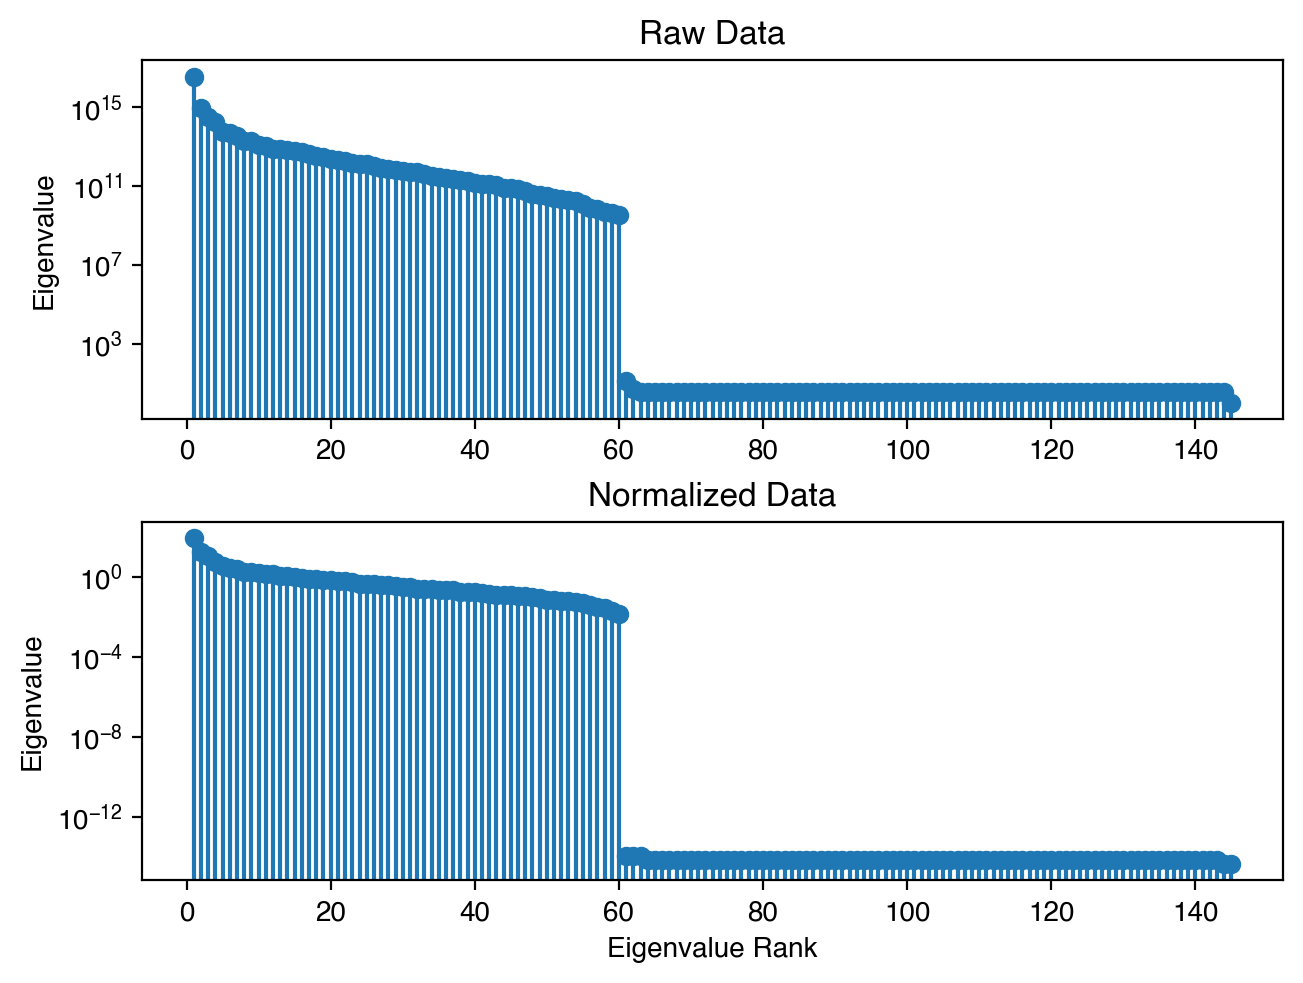

In [3]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,layout="constrained")

ax1.stem(np.arange(1,len(S)+1),S)
ax1.set_yscale("log")
ax1.set_ylabel('Eigenvalue')
ax1.set_title("Raw Data")

ax2.stem(np.arange(1,len(Sz)+1),Sz)
ax2.set_yscale("log")
ax2.set_xlabel('Eigenvalue Rank')
ax2.set_ylabel('Eigenvalue')
ax2.set_title("Normalized Data")


Let's zoom into the leading low order modes 1 though 10.  Here we can see a bit more of the structure and notice that the leading eigenvalue of the non-normalized data is very large and substantially larger than the subsequent modes, which steeply approach zero (although in part this is due to the magnitude of the eigenvalues from this full variance matrix).   It is evident though that the eigenvalue structure of normalized and non-normalized data are different. 

Text(0.5, 1.0, 'Normalized Data')

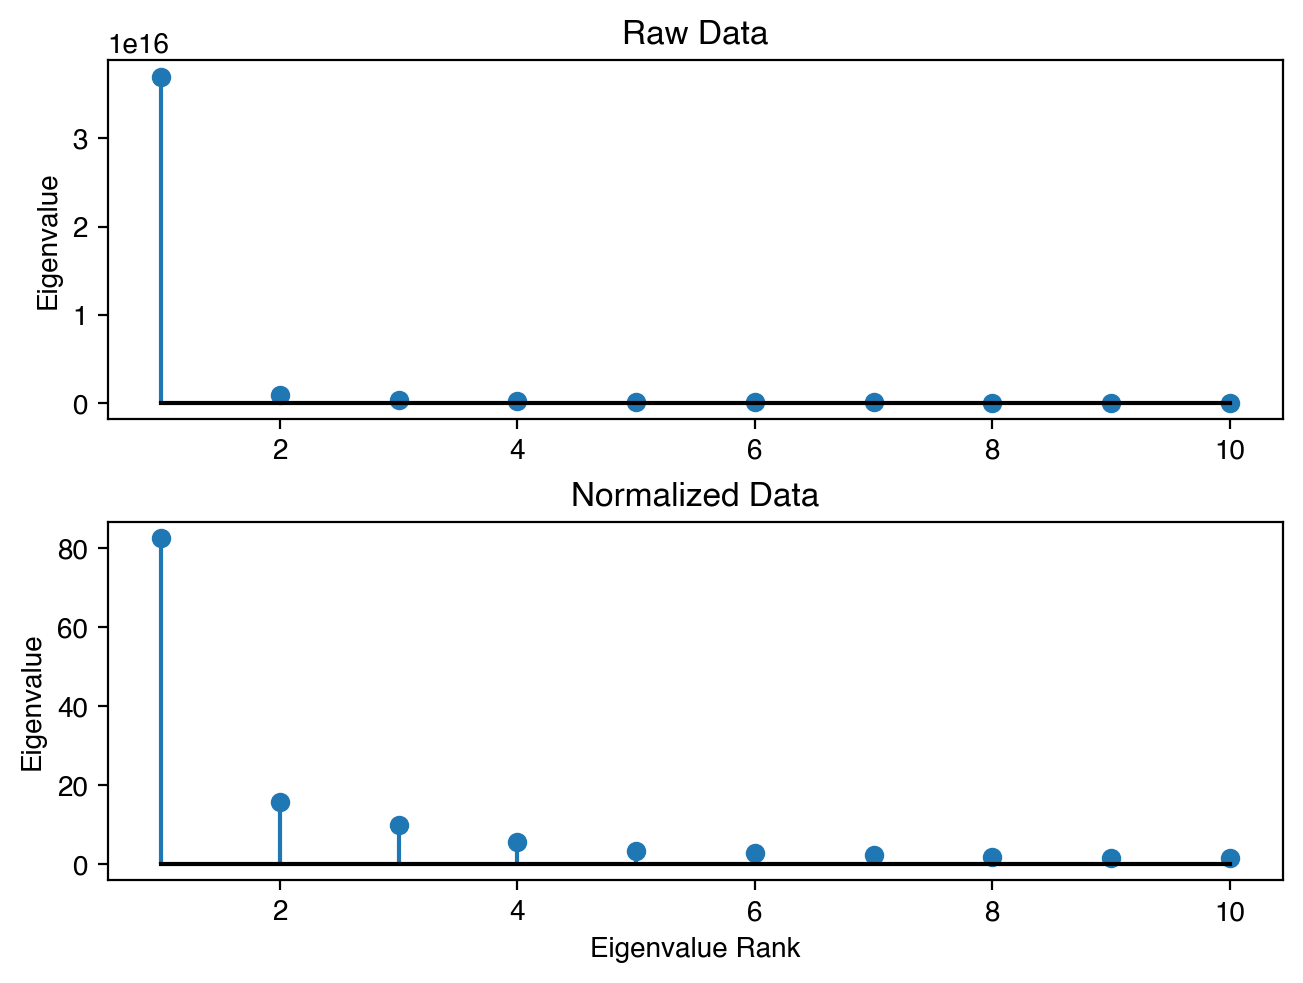

In [4]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,layout="constrained")

ax1.stem(np.arange(1,11),S[:10],basefmt="k")
ax1.set_ylabel('Eigenvalue')
ax1.set_title("Raw Data")


ax2.stem(np.arange(1,11),Sz[:10],basefmt="k")
#ax2.set_yscale("log")
ax2.set_xlabel('Eigenvalue Rank')
ax2.set_ylabel('Eigenvalue')
ax2.set_title("Normalized Data")


Let's plot a scree plot but just looking at the leading low order modes from the normalized data eigenvalues below. We can see that mode 1 has a larger eigenvalue (and percent variance explained) than the subsequent modes, but that perhaps 4 or 5 of the modes are prominent enough that we might consider anayzing them?   But how might we chose?  The scree plot is your first examination of the potential meaningfulness of your eigendecomposition, but it should seldom be your last. 

Text(0, 0.5, 'PERCENT VARIANCE EXPLAINED')

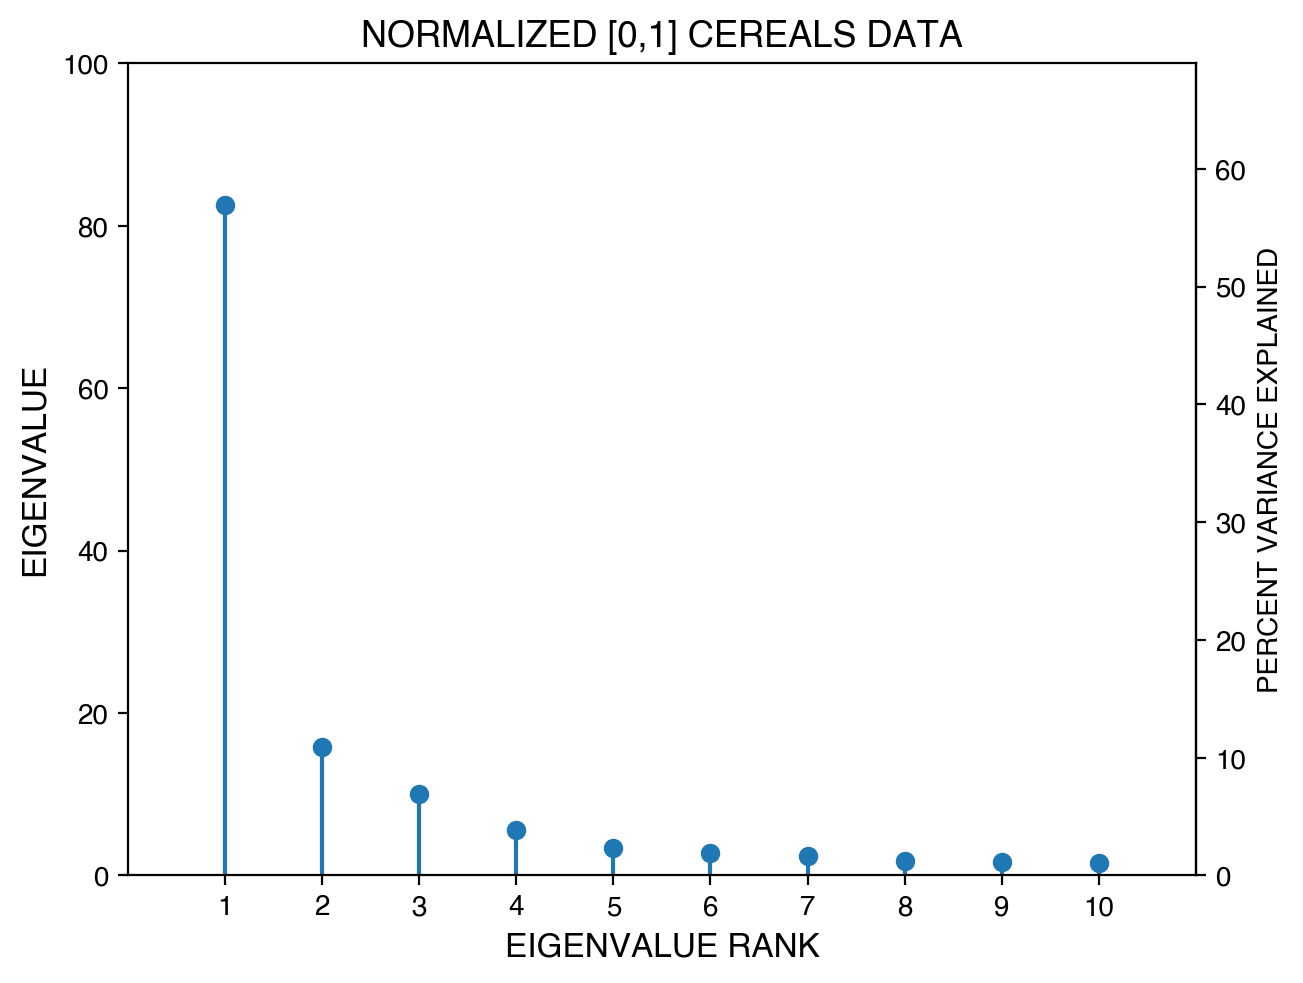

In [5]:
fig, (ax2) = plt.subplots(nrows=1,ncols=1,layout="constrained")

ax2.stem(np.arange(1,11),Sz[:10],basefmt=" ")
ax2.set_ylim([0,100])
ax2.set_xlim([0,11])
ax2.set_xlabel('EIGENVALUE RANK',fontsize=12)
ax2.set_ylabel('EIGENVALUE',fontsize=12)
ax2.set_title("NORMALIZED [0,1] CEREALS DATA",fontsize=13)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10]);

evt = np.sum(Sz)

# Convert eigenvalue to variance
e_v = lambda e_v: (e_v/np.sum(evt)) * 100

# Convert variance to eigenvalue
v_e = lambda v_e: (v_e/100)/np.sum(evt)

# Secondary y-axis with variance explained on it
secax = ax2.secondary_yaxis('right', functions=(e_v,v_e))
secax.set_ylim([0,100])
secax.set_ylabel('PERCENT VARIANCE EXPLAINED')

## Kaiser-Guttman (Eigenvalue-1)

The [Kaiser](https://doi.org/10.1177/001316446002000116) [Guttman](https://link.springer.com/article/10.1007/BF02289162) Criteria (sometimes called the eigenvalue=1 rule), suggests retaining any modes with an eigenvalue greater than 1 for a factorization of the correlation matrix or normalized data.  Plotting the eigenvalue=1 line on the scree plot below with out normalized data eigenvalues suggest up to 14 modes (!) could be interpretable. 

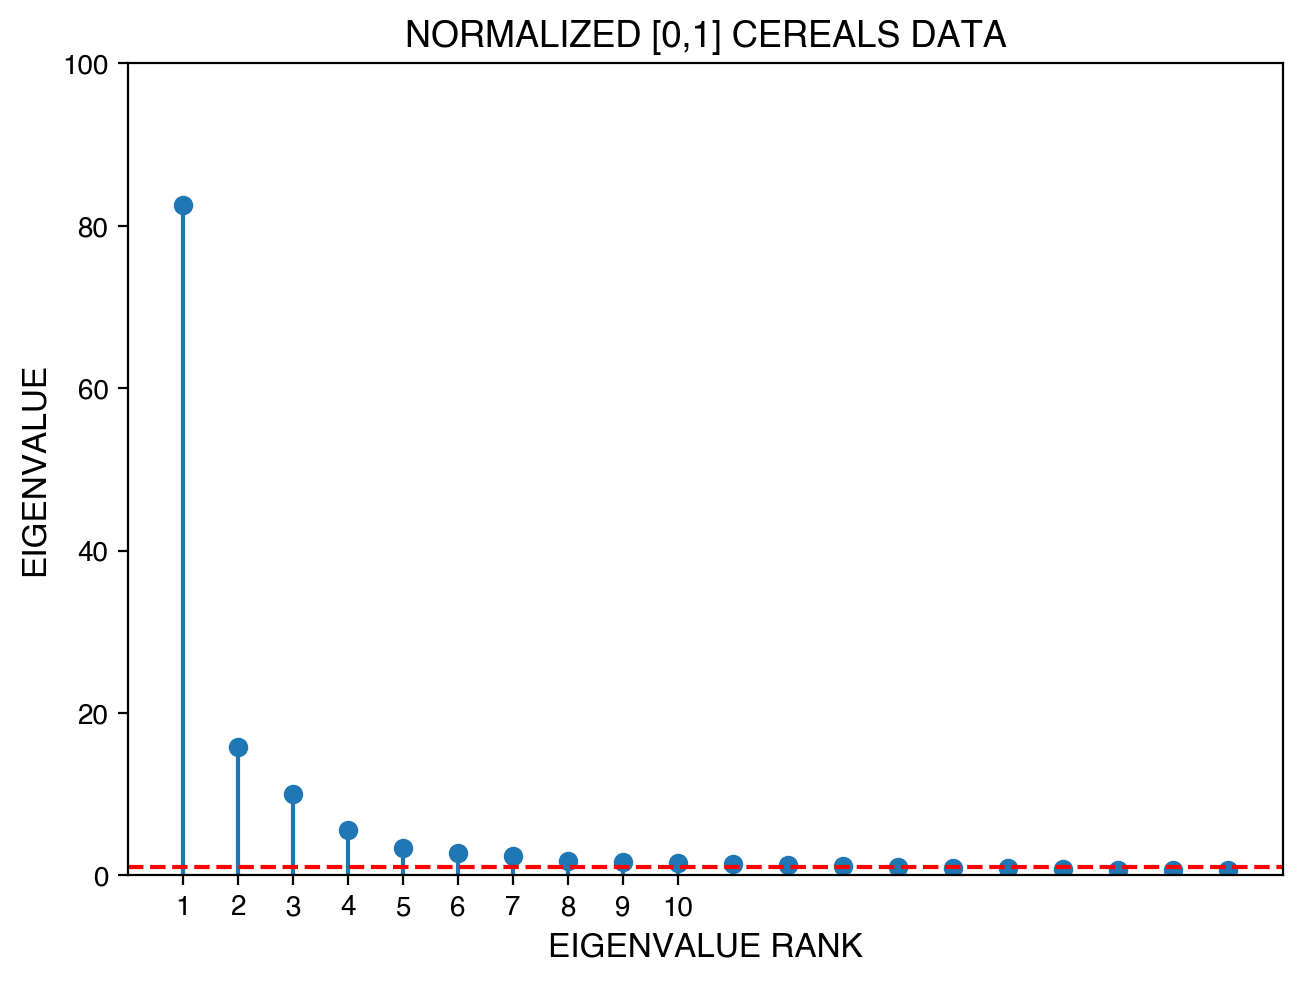

In [6]:
## Kaiser-Guttman (Eigenvalue-1)
fig, (ax2) = plt.subplots(nrows=1,ncols=1,layout="constrained")

ax2.stem(np.arange(1,21),Sz[:20],basefmt=" ")
ax2.set_ylim([0,100])
ax2.set_xlim([0,21])

ax2.plot([0,21],[1,1],color="red",linestyle="--")
#ax2.set_yscale("log")
ax2.set_xlabel('EIGENVALUE RANK',fontsize=12)
ax2.set_ylabel('EIGENVALUE',fontsize=12)
ax2.set_title("NORMALIZED [0,1] CEREALS DATA",fontsize=13)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10]);

## North's Rule of Thumb

North's Rule of Thumb ([North et al. 1982](https://doi.org/10.1175/1520-0493(1982)110%3C0699:SEITEO%3E2.0.CO;2)) attempts to account for 'the sampling errors incurred when too small a sample is available'.  In otherwords, if adjacent eigenvalues are very similar to one another, due to sampling error alone it is possible they are not robustly distinguishable from one another.  While the paper linked above goes into this in greater detail, it also proposes a tractable estimation of eigenvalue uncertainty:

$
\Delta \lambda_k \approx \lambda_k \sqrt{\frac{2}{N}}
$

Or, the uncertainty around any eigenvalue $\lambda_k$ can be approximated by the product of that eigenvalue $\lambda_k$ and the square root of 2 over the effective sample size.  In truth, there are no set guidelines for how to best determine the effective sample size $N$, although there are various simple ways of accounting for temporal autocorrelation in individual time series in our matrix (we'll discuss these later in class), so often we use the sample size $N$ (e.g. the number of observations).  This means that the error bars that we get from this calculation are probably too small, and you should factor this in accordingly.

Let's write a Python function here in the notebook to calculate North's Rule for us, and then we will call this function for the eigenvalues from the normalized data:

In [7]:
def northTest(ev, varscaled=False):
       
    error_factor = np.sqrt(2.0 / len(ev)) # the square root scaling
        
	# allow for scaling of the eigenvalues by the total variance (sum of the eigenvalues).
    if varscaled:
        error_factor = (error_factor/np.sum(ev)) * 100  # if the eigenvalues provided are actually percent variance, allow for this

    error_range = error_factor * ev # apply the square root scaling to the eigenvalues provided
	
    return (error_range) # returnt the error ranges
        

# now call the above function, passing the eigenvalues as input
north_errors = northTest(Sz)

Let's plot the eigenvalues now with the error bars (`plt.errorbar` from Matplotlib) from the North Test that we calculated above:

(0.0, 100.0)

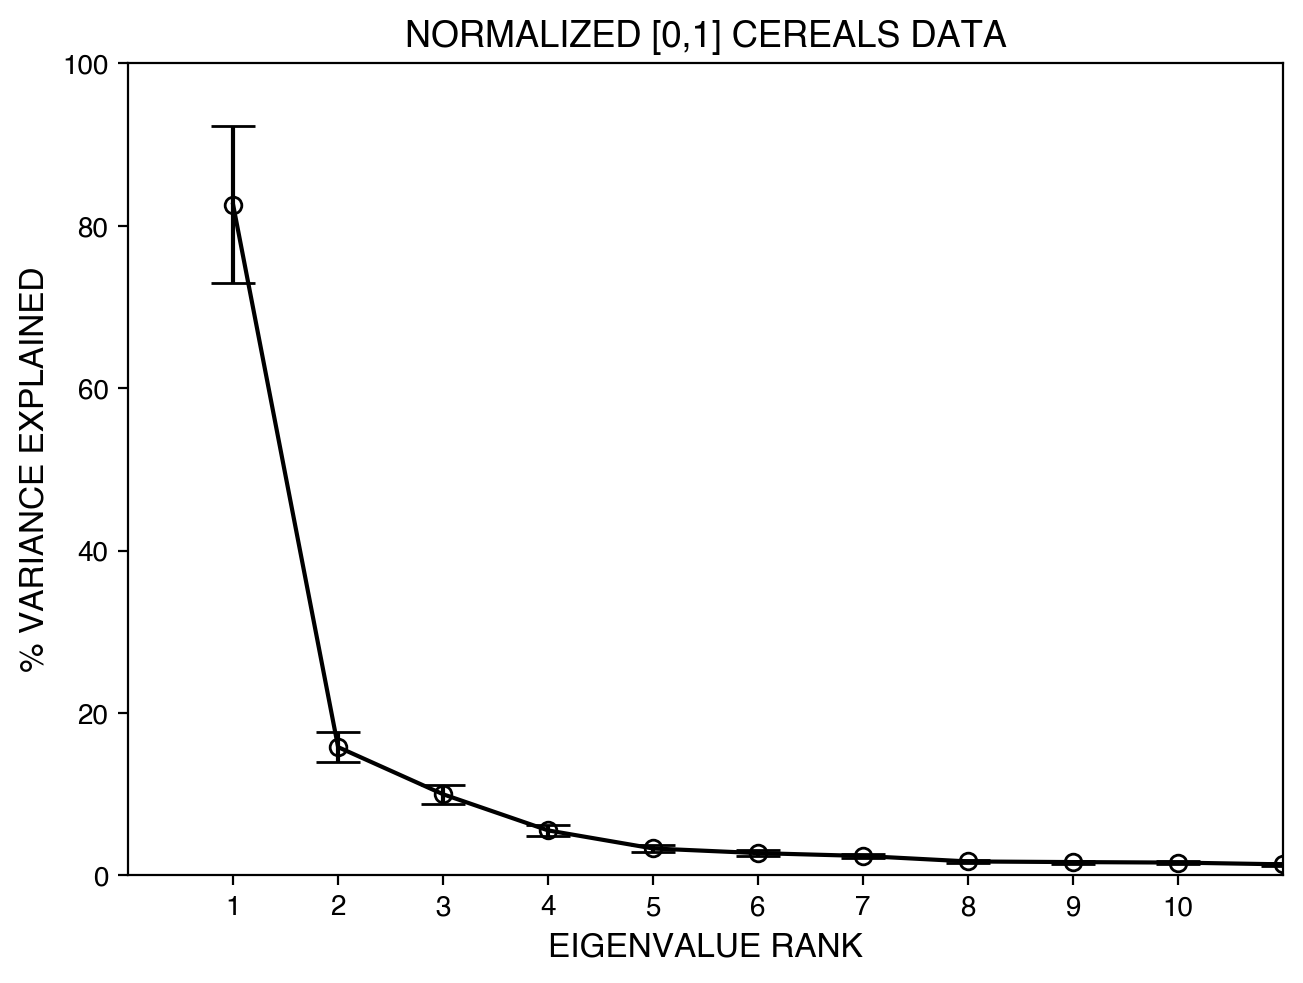

In [8]:
fig, (ax2) = plt.subplots(nrows=1,ncols=1,layout="constrained")

plt.errorbar(np.arange(1,len(Sz)+1),Sz, yerr=north_errors, capsize=8, fmt="ko-",markerfacecolor='none')
ax2.set_xlabel('EIGENVALUE RANK',fontsize=12)
ax2.set_ylabel('% VARIANCE EXPLAINED',fontsize=12)
ax2.set_title("NORMALIZED [0,1] CEREALS DATA",fontsize=13)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10])
ax2.set_xlim((0,11))
ax2.set_ylim((0,100))


We can see that there is no overlap between the error bars for eigenvalues 1, 2, 3, and 4.  The eigenvalue errors for mode 5 overlap with mode 6, and so on.  So we might conclude that up to 5 modes could be interpretable or distinguishable from each other. 

## Broken Stick Model

The idea of the Broken Stick model comes to us from MacArthur 1957.  The idea is that if you took a unit length and randomly broke it into $N$ pieces, you would get a distribution of sizes (fractions of the whole).  For us then in EOFs, the broken stick suggests how the total variance might be randomly distributed:

$
b_{i} = \frac{1}{N}\sum_{i=k}^{N} \frac{1}{i}
$

The equation above says that if you randomly divide the total variance into $N$, the expected proportion $b_i$ of the $ith$ largest proportion is the sum of 1 divided by the $ith$ through $Nth$ values.  So if we have 5 eigenvalues, the expected fraction of variance in the 1st mode is:

$
(1+1/2+1/3+1/4+1/5)/5 = 0.457
$

Let's once again create a function here in the notebook to do this for us:

In [9]:
def broken_stick_model(ev):
    # ev is the vector of eigenvalues 
    n = len(ev)
    bsm = np.empty(n)  # Pre-allocate an array
    for i in range(1, n + 1):
        bsm[i - 1] = np.sum(1 / np.arange(i, n + 1)) / n # bsm will sum to 1, it is the fraction of the whole for each segment
    
    return (bsm)
 
# Apply Broken Stick Function to our eigenvalues    
bsm = broken_stick_model(Sz)


And now let's plot our eigenvalues vs. the broken stick model applied to the variance explained (we could also apply it to the eigenvalues themselves - the `bsm` is just the fraction of the whole expected):

(0.0, 70.0)

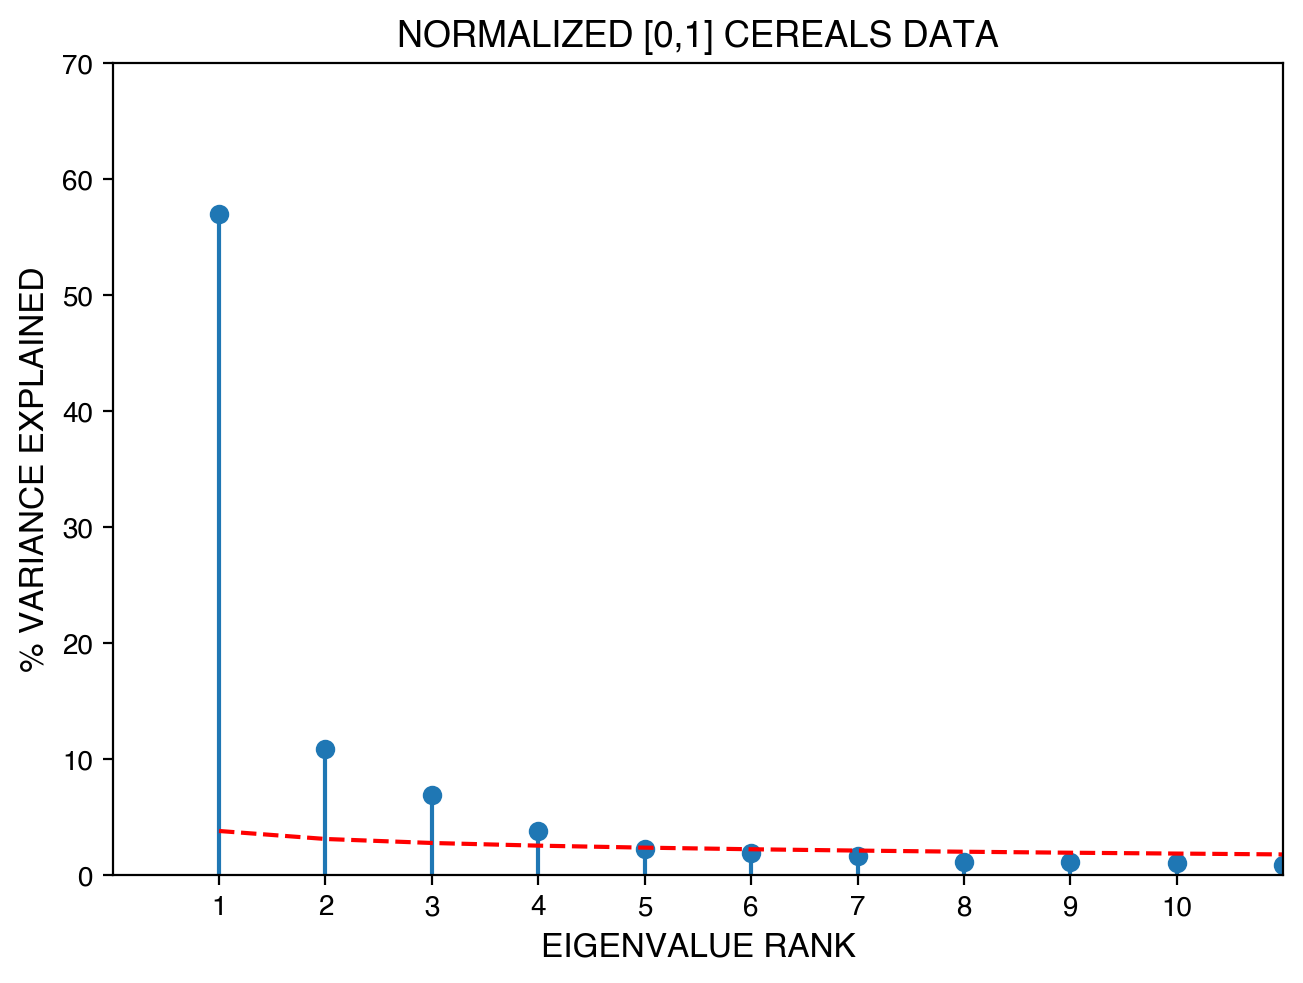

In [10]:
fig, (ax2) = plt.subplots(nrows=1,ncols=1,layout="constrained")

ax2.stem(np.arange(1,len(Sz)+1),100*Sz/Sz.sum(),basefmt=" ")
ax2.plot(np.arange(1,len(Sz)+1),bsm*100,linestyle="--",color="red")
ax2.set_xlabel('EIGENVALUE RANK',fontsize=12)
ax2.set_ylabel('% VARIANCE EXPLAINED',fontsize=12)
ax2.set_title("NORMALIZED [0,1] CEREALS DATA",fontsize=13)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10])
ax2.set_xlim((0,11))
ax2.set_ylim((0,70))

Here we might once again think that 4 modes are meaningful beyond our null random model, but we might also be wary of whether 5 is 'close' to the cut-off.

## Monte Carlo approaches to significance testing

None of the rules above take into account anything about our data explicitly -- they are null models for uncertainty or a randomness floor, but they have little to do with the structure of our data.  As we read in [Overland and Preisendorfer (1982)](https://doi.org/10.1175/1520-0493(1982)110<0001:ASTFPC>2.0.CO;2), an alternative approach is to simulate the level of potential noise in our data using spatially and temporally uncorrelated processes.  You did this in Homework #3 as well.  Here we take a closer look at this process and consider both Gaussian (white) noise and red noise, a test we'll encounter on Homework #4.

Let's create a look that allows us to (1) create a random matrix of Gaussian noise similar to our real data, (2) get the covariance of that noies matrix, (3) calculate the eigenvalues and eigenvectors, and (4) save the eigenvalues for later use:

In [11]:
# how many iterations? Be sure to start small until you know how long this might take
iterations = 10

# save the size of our data matrix
mrows, ncols = cereals.shape

# create an array full of NaN values to acccept the random eigenvalues we'll generate 
S_simulated = np.full((iterations,len(S)),np.nan) # rows of iteration number, columns of the length of the eigenvalue vector

# loop through by iteration ... 
for i in range(iterations):
    x = np.random.normal(cereals.values.mean(axis=0),cereals.values.std(axis=0),cereals.values.shape) # random normal matrix the size of our data with mean and standard deviation of our data
    x = x - x.mean(axis=0) # remove the mean
    Cx = np.cov(x,rowvar=False,ddof=1) # get the covariance of the random matrix
    Ux,Sx,Vx = np.linalg.svd(Cx) # factor the covariance matrix into eigenvalues and eigenvectors
    S_simulated[i,:] = Sx # save the simulated eigenvalues
    
S_simulated_var = 100 * (S_simulated/np.sum(S_simulated,axis=1)[:,None]) # turn eigenvalues into perfect variance

ci95 = np.percentile(S_simulated,95,axis=0) # 95th percentile of the eigenvalues
ci95var = np.percentile(S_simulated_var,95,axis=0) # 95th percentile of the variance explained


Let's plot the 95th percentile confidence interval vs. our non-normalized data - what do you observe?  In light of your reading of Overland and Preisendorfer, how do you interpret this? 

(0.0, 11.0)

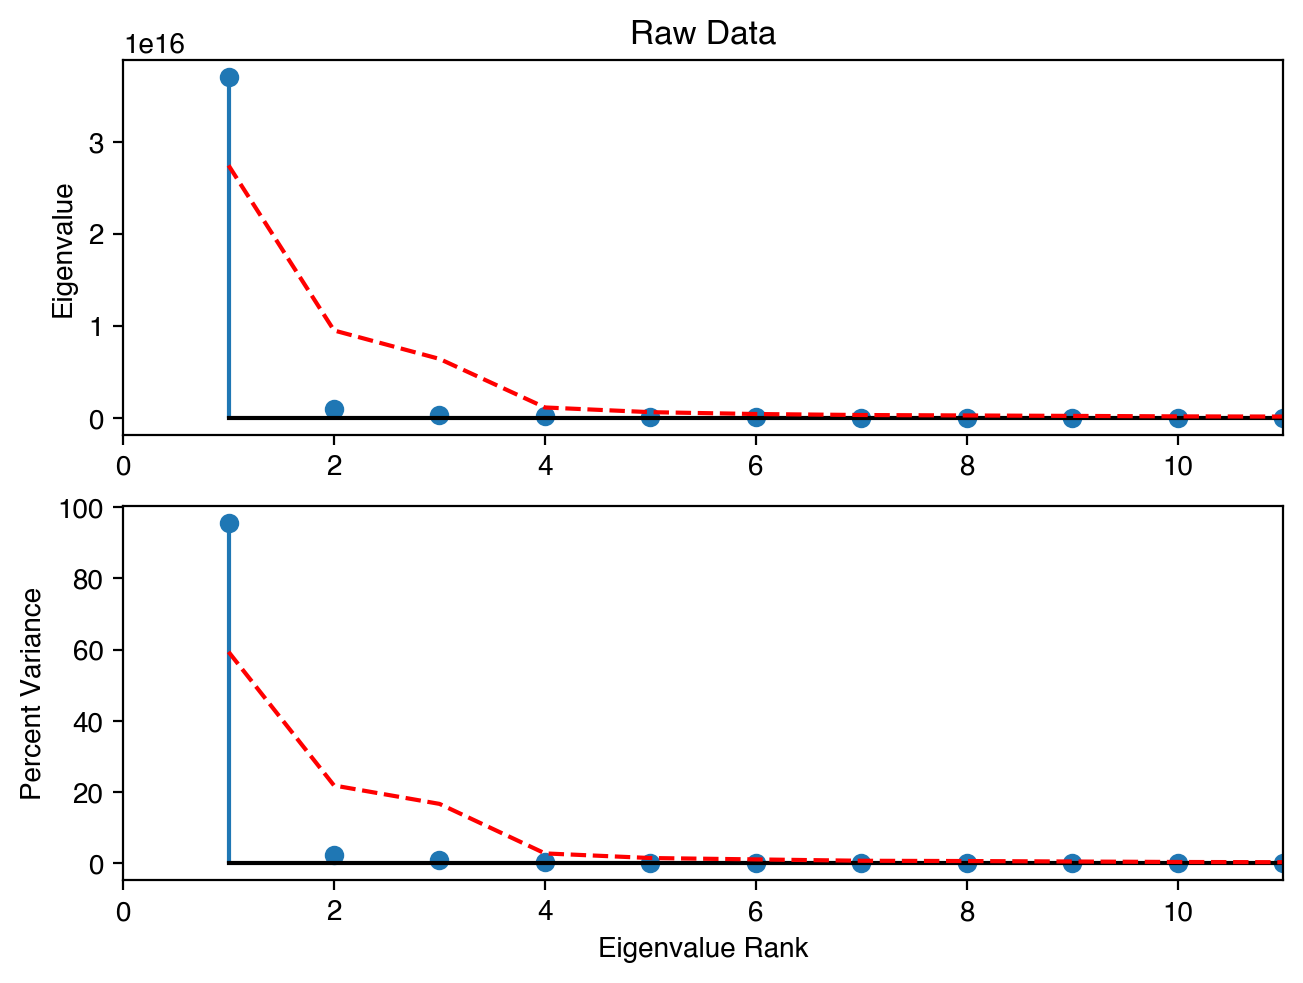

In [12]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,layout="constrained")

ax1.stem(np.arange(1,len(S)+1),S,basefmt="k")
ax1.plot(np.arange(1,len(S)+1),ci95,linestyle="--",color="red")
ax1.set_ylabel('Eigenvalue')
ax1.set_title("Raw Data")
ax1.set_xlim((0,11))

ax2.stem(np.arange(1,len(S)+1),100*S/S.sum(),basefmt="k")
ax2.plot(np.arange(1,len(S)+1),ci95var,linestyle="--",color="red")
#ax2.set_yscale("log")
ax2.set_xlabel('Eigenvalue Rank')
ax2.set_ylabel('Percent Variance')
ax2.set_xlim((0,11))



Let's do the same procedure, but now using our normalized data matrix:

In [13]:
# how many iterations? Be sure to start small until you know how long this might take
iterations = 10

# create an array full of NaN values to acccept the random eigenvalues
Sz_simulated = np.full((iterations,len(Sz)),np.nan)

for i in range(iterations):
    xz = np.random.normal(cerealz.values.mean(axis=0),cerealz.values.std(axis=0),cerealz.values.shape)
    xz = xz - xz.mean(axis=0)
    Cxz = np.cov(xz,rowvar=False,ddof=1)
    Uxz,Sxz,Vxz = np.linalg.svd(Cxz)
    Sz_simulated[i,:] = Sxz
    
Sz_simulated_var = 100 * (Sz_simulated/np.sum(Sz_simulated,axis=1)[:,None])

ci95z = np.percentile(Sz_simulated,95,axis=0)
ci95varz = np.percentile(Sz_simulated_var,95,axis=0)

Now let's plot the 95th percentile confidence interval vs. our normalized data - what do you observe? How is this different from using the non-normalize data? 

(0.0, 11.0)

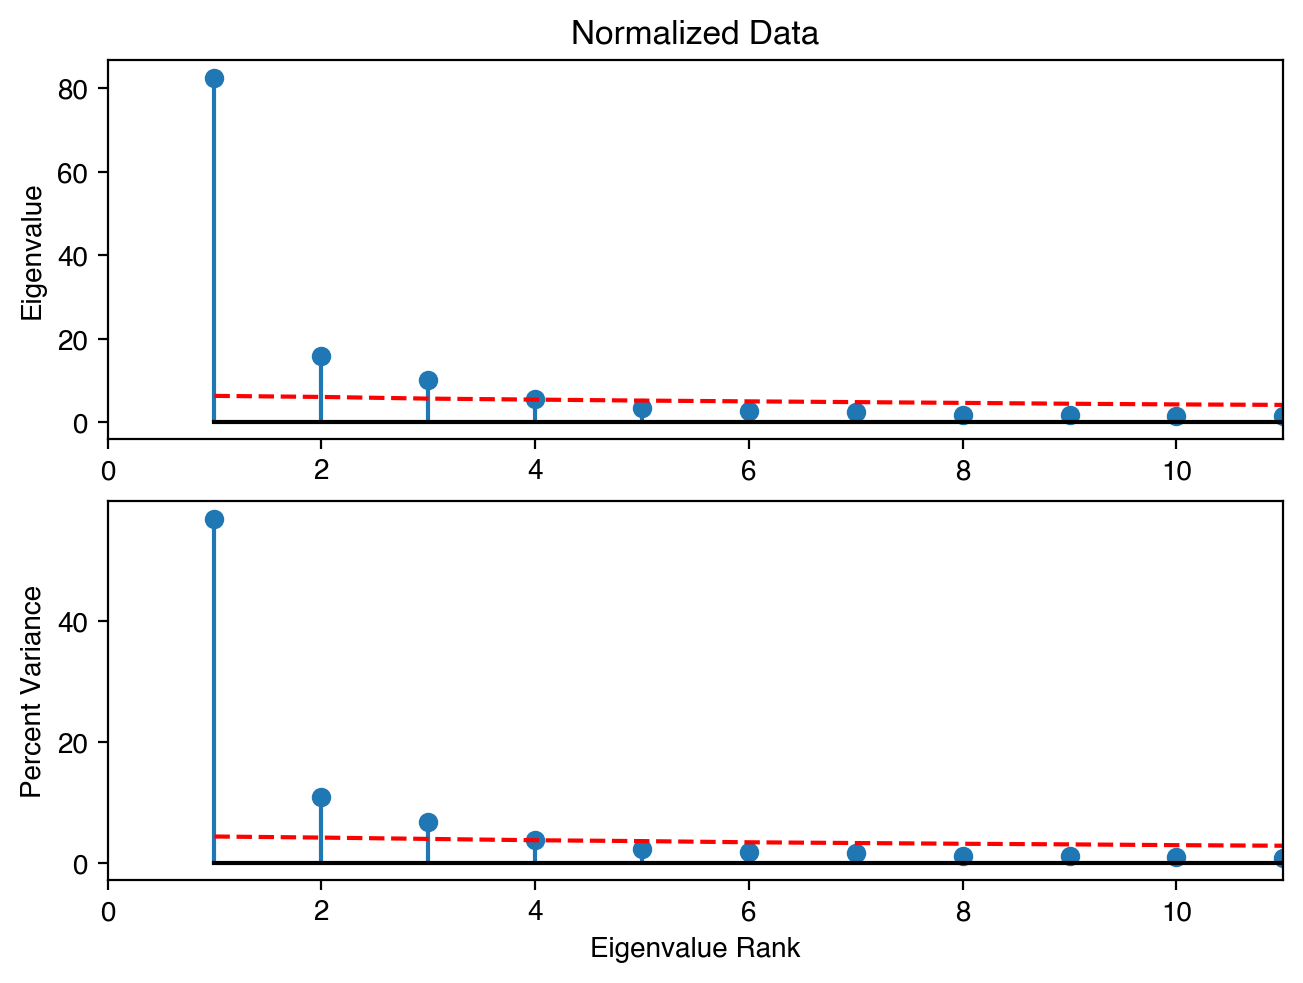

In [14]:
fig, (ax1,ax2) = plt.subplots(nrows=2,ncols=1,layout="constrained")

ax1.stem(np.arange(1,len(Sz)+1),Sz,basefmt="k")
ax1.plot(np.arange(1,len(Sz)+1),ci95z,linestyle="--",color="red")
ax1.set_ylabel('Eigenvalue')
ax1.set_title("Normalized Data")
ax1.set_xlim((0,11))

ax2.stem(np.arange(1,len(Sz)+1),100*Sz/Sz.sum(),basefmt="k")
ax2.plot(np.arange(1,len(Sz)+1),ci95varz,linestyle="--",color="red")
#ax2.set_yscale("log")
ax2.set_xlabel('Eigenvalue Rank')
ax2.set_ylabel('Percent Variance')
ax2.set_xlim((0,11))

Let's take a closer look at the eigenvalues in the leading modes:

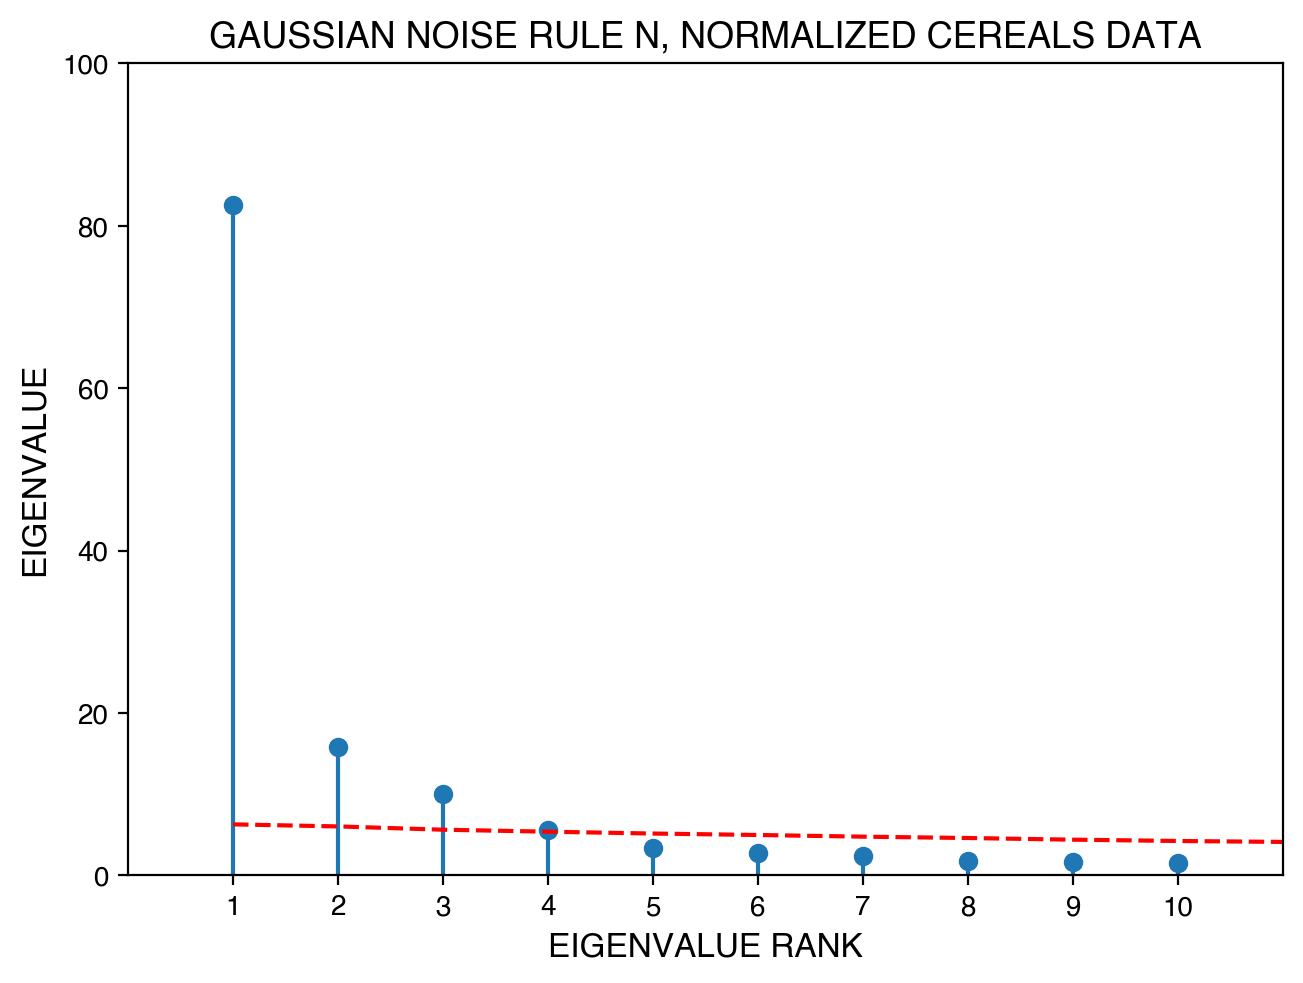

In [15]:
fig, (ax2) = plt.subplots(nrows=1,ncols=1,layout="constrained")

ax2.stem(np.arange(1,11),Sz[:10],basefmt=" ")
ax2.set_ylim([0,100])
ax2.set_xlim([0,11])
ax2.plot(np.arange(1,len(Sz)+1),ci95z,linestyle="--",color="red")

#ax2.set_yscale("log")
ax2.set_xlabel('EIGENVALUE RANK',fontsize=12)
ax2.set_ylabel('EIGENVALUE',fontsize=12)
ax2.set_title("GAUSSIAN NOISE RULE N, NORMALIZED CEREALS DATA",fontsize=13)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10]);

And the variance explained plot:

(0.0, 70.0)

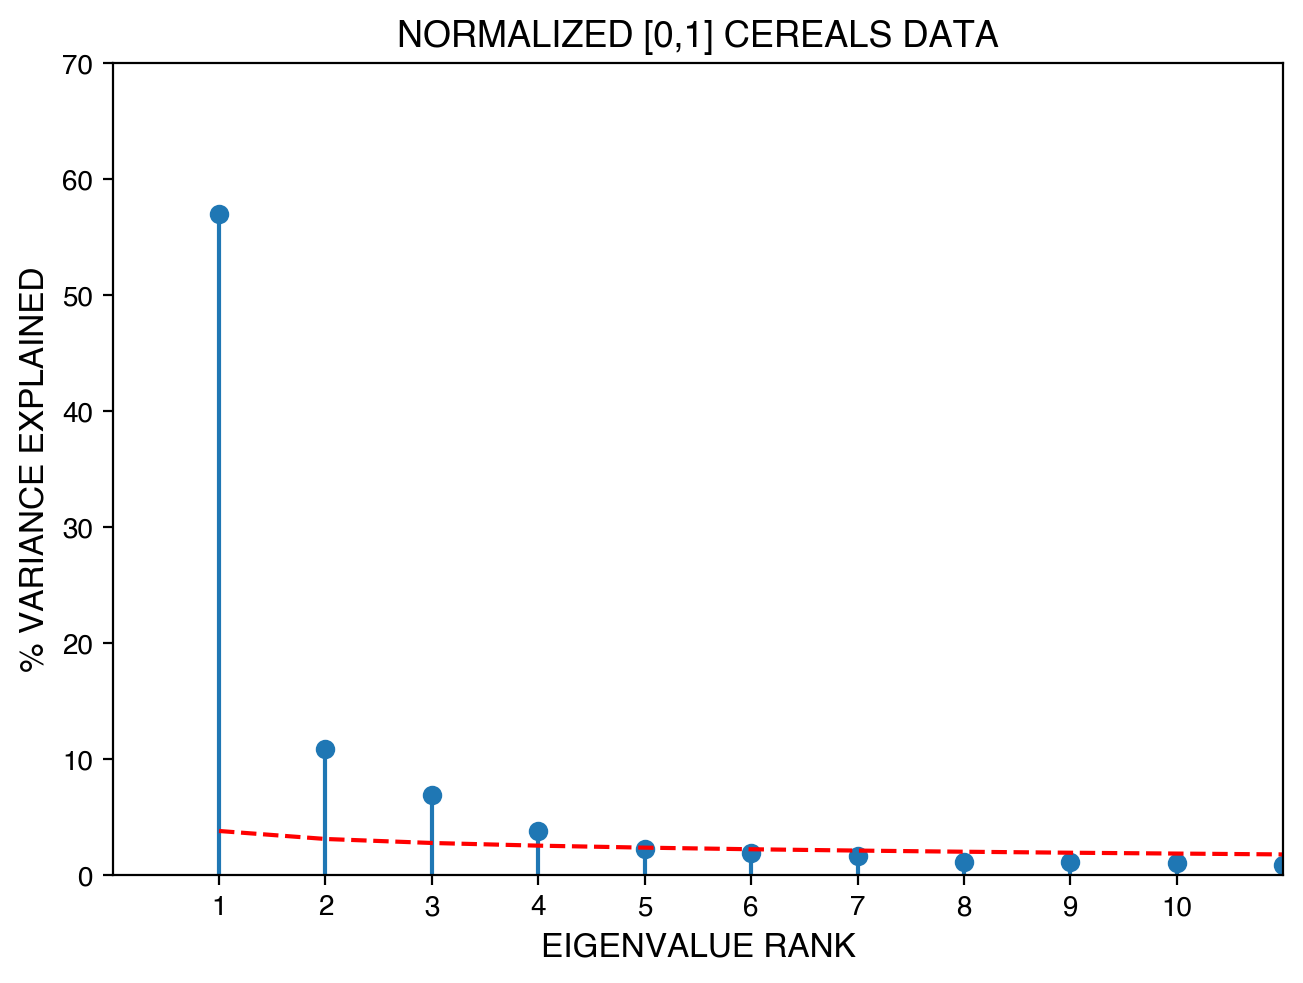

In [16]:
fig, (ax2) = plt.subplots(nrows=1,ncols=1,layout="constrained")

ax2.stem(np.arange(1,len(Sz)+1),100*Sz/Sz.sum(),basefmt=" ")
ax2.plot(np.arange(1,len(Sz)+1),bsm*100,linestyle="--",color="red")
ax2.set_xlabel('EIGENVALUE RANK',fontsize=12)
ax2.set_ylabel('% VARIANCE EXPLAINED',fontsize=12)
ax2.set_title("NORMALIZED [0,1] CEREALS DATA",fontsize=13)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10])
ax2.set_xlim((0,11))
ax2.set_ylim((0,70))

Using Gaussian noise as a our null hypothesis, this test suggests that at the 95% confidence level, we might interpret 4 modes as meaningful and significant enough for further interpretation.  However, note how close mode 5 is to being significant.  Once again, while this Monte Carlo approach suggests a significant level and selection rule, we should be aware of how different assumptions -- about the nature of the null hypothesis, the number of iterations, the somewhat arbitrary selection of 95% vs 90 or 99%, etc. -- might affect this decision.

## Rule 'N' with Red Noise

As we'll discuss more in the lecture, Gaussian (white) noise (with equal variances across frequencies) might not be the most appropriate null model to simulate, particularly for geophysical space-time fields of data, which tend to have a red spectrum, where we find more variance at the lower frequencies and less at the high.

We can do a similar test as above, but this time simulating a red noise process.  In lecture, we discussed a simple equation for such a process:

$
X_{t} = \phi_{1} X_{t-1} + Z_{t}, Z \sim \mathcal(N)(0,\sigma^2)
$

In otherwords, a value of $X$ at time $t$ is a function of the value of $X$ at the prior time step $t-1$ plus some random noise with a mean of zero and standard deviation of 1.  If we can estimate a value for $\phi$ we could simulate a simple noise process where each time period was dependent on the one before. 

For a Python specific solution for processes without a zero-mean and non-unit standard deviation, see here: https://stackoverflow.com/questions/33898665/python-generate-array-of-specific-autocorrelation

For a good and tractable description of white and red noise processes, see here: https://atmos.washington.edu/~breth/classes/AM582/lect/lect8-notes.pdf

For more on red noise processes, see here: https://atmos.uw.edu/~dennis/552_Notes_6a.pdf

In the code block below, I perform a signal red noise simulation based on the non-normalized version of the cereals.  Data.  I get the size of the data matrix as well as the mean and standard deviation of each column (in this case, remember, we already removed the mean, but for `cereals` I left the variance intact).  I then calculate the lag-one autocorrelation - that is, the correlation of each column with itself lagged one year.  Pandas supplies `.autocorr()` for this purpose, but it is only for Series (!?!) not DataFrames, so we need to use `.apply` and a lambda function to use it on every column. 

We then prepare a matrix the same size as our data in which we will generate the red noise series.  

To get ready to generate the red noise, we modify the mean value $\mu$ to account for the non-zero mean and we calculate the standard deviation of the Gaussian process to account for the lag-1 autocorrelation and the non unit variance. 

Finally, we are ready to generate our red noise matrix.  The 0th row is an initial random draw from the zero-centered normal distribution plus the mean value.  The loop then goes row by row and calculate the value in that row as a function of the lag-one autocorrelation plus a random draw from the normal distribution plus the mean. 

We can then plot this red noise simulation of our data matrix - a few thins will be clear - there are some very high variance processes and there are many low variance ones.  The high variance processes clearly also have a lot of persistence - they tend to stay either positive or negative and subsequent values are typically close to these that come before and after. If you run the code block over and over again, you'll see the effect of the random re-generation of the red noise series each time.  

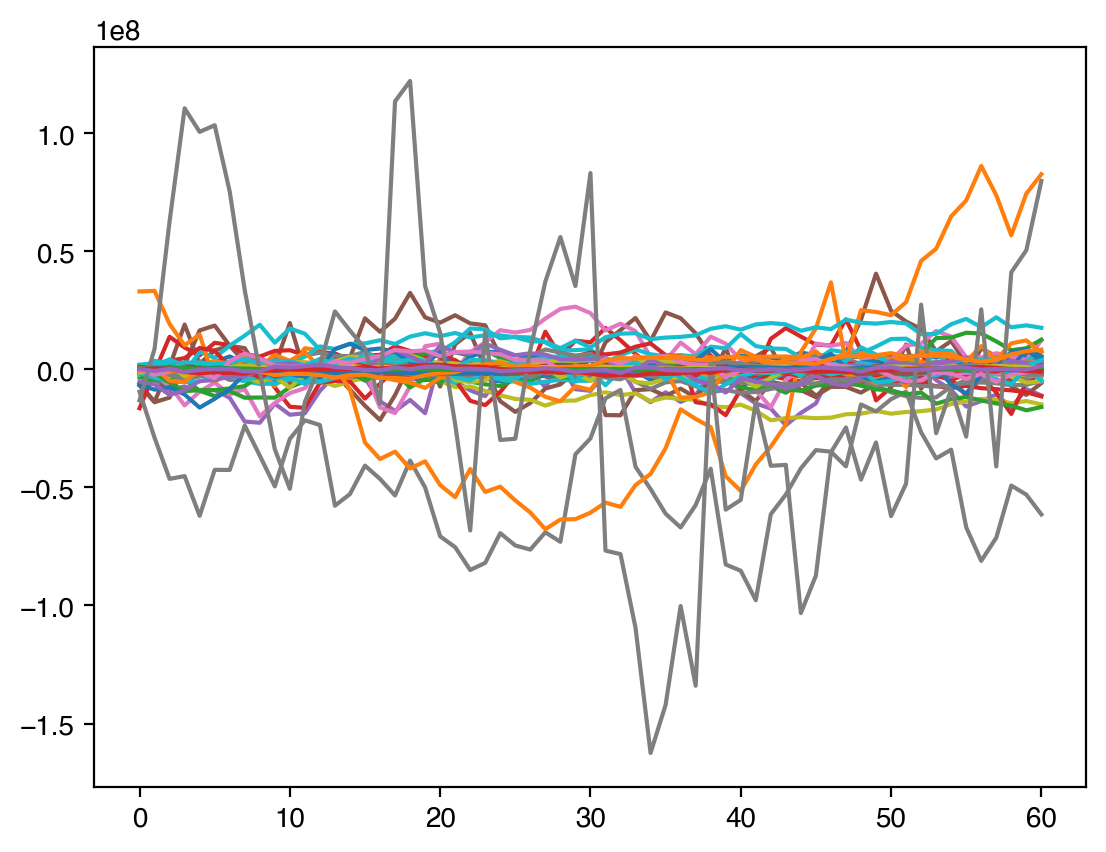

In [17]:
# how many rows and columns of data will we simulate?
nrows, ncols = cereals.shape 

# what is the mean of each column?
mu = np.mean(cereals.values,axis=0)

# what is the standard deviation of each column? 
sigma = np.std(cereals.values,axis=0)

# determine a mean phi value to use
# acf1 = 0.5 could in some instances apply a single AR1 value to all the columns, or get one for each column:
acf1 = cereals.apply(lambda x: x.autocorr()) # use .apply because autocorr is for series, not DataFrames (?!)

# create an empty matrix full of NaNs to accept the red noise null simulations
signal = np.full(cereals.shape, np.nan) 

# the below gives more consistent results - could also alternatively reset mean and variance afterwards
c = mu * (1 - acf1) # for a non-zero mean
sigma_e = np.sqrt((sigma ** 2) * (1 - acf1 ** 2)) # for a non-unit standard deviation

# set the first value in the array as a random draw from the normal distribution with the correct mean and variance
signal[0,:] = np.array([c + np.random.normal(0, sigma_e, size=ncols)])

# look through for each row, caculating each value as a function of the one before
for i in range(1, nrows):
    signal[i,:] = np.array([c + (acf1 * signal[i-1,:]) + np.random.normal(0, sigma_e,size=ncols)])

# take a look at the simulated series    
plt.plot(signal);        

We can plot a histogram of each lag-one autocorrelation we calculated from the data matrix - we see that many of the individual country cereal production time series have strong persistence: 

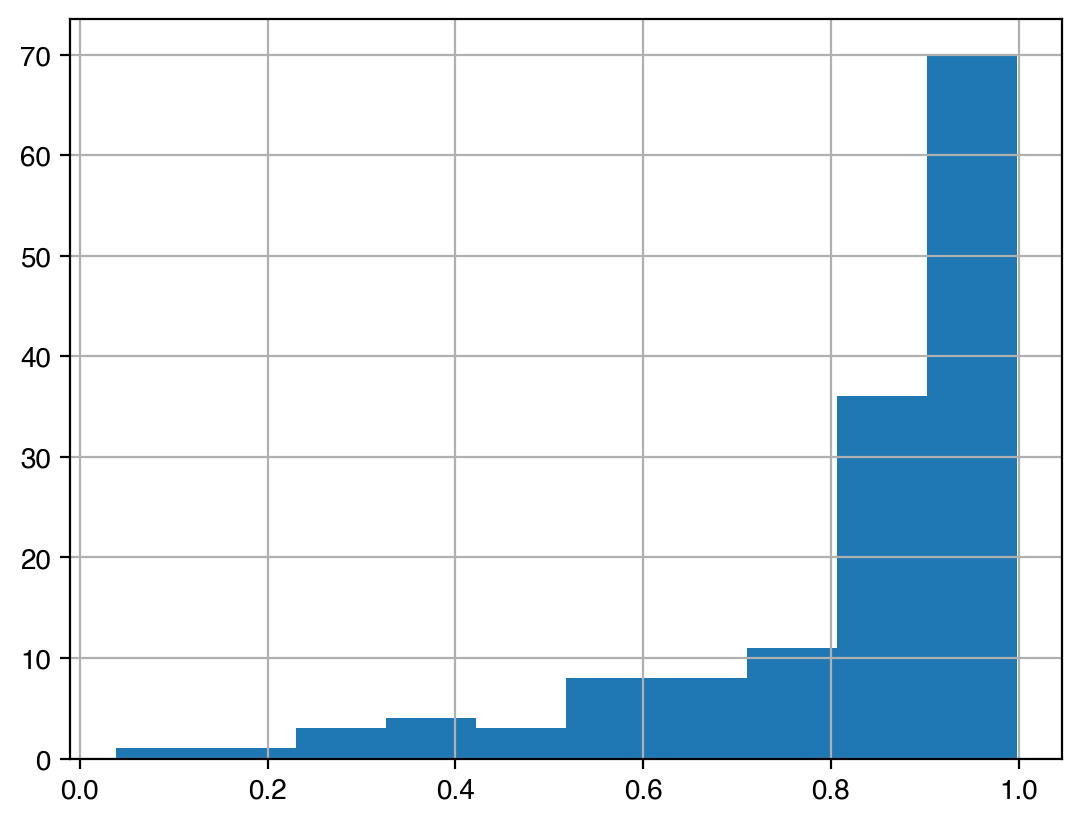

In [18]:
acf1.hist();

Let's now perform an actual Red Noise Monte Carlo Rule N significance test on our normalized data matrix.  I'll follow the same procedure as above to generate the random red noise simulations.  This time though we'll iterate to do this many times (I suggest starting with 10 to see how long it takes, then trying 100 and 1000).  We'll generate a null red noise simulated data series called `arnull` on each loop that is meant to mimic the persistence structure of our real data while still being random.  Having done that, we'll calculate the covariance (correlation) matrix and get the eigenvalues and eigenvectors from `svd`.   We'll save the eigenvalues on each iteration through the loop in 

In [19]:
# how many rows and columns of data will we simulate?
nrows, ncols = cerealz.shape 

# what is the mean of each column
mu = np.mean(cerealz.values,axis=0)

# what is the 
sigma = np.std(cerealz.values,axis=0)

# determine a mean phi value to use
acf1 = cerealz.apply(lambda x: x.autocorr()) # use apply because autocorr is for series, not DataFrames (?!)

# how many iterations will we do? 
iterations = 1000 # about 10 seconds for 1000

# create the empty matrix to hold the simulated red noise eigenvalues
ars_simulated = np.full((iterations,len(Sz)),np.nan)

# loop through the j iterations with an inner loop through the i rows of the simulated red noise matrix
for j in range(iterations):
    # create an empty matrix to accept the red noise null simulation
    arnull = np.full(cerealz.shape, np.nan) 

    # mean value and the variance of the random distribution
    c = mu # we have a zero-mean process
    sigma_e = np.sqrt((1 - acf1 ** 2))  # sets the appropriate standard deviation for [0,1] data

    # set the first value in the array as a random draw with the correct mean and variance
    arnull[0,:] = np.array([c + np.random.normal(0, sigma_e, size=ncols)])

    # inner loop i that goes row-by-row to generate the red noise simulation
    for i in range(1, nrows):
        arnull[i,:] = np.array([c + (acf1 * arnull[i-1,:]) + np.random.normal(0, sigma_e,size=ncols)])
    
    # calculate the covariance and then use svd to get the eigenvalues and eigenvectors
    Cx = np.cov(arnull,rowvar=False,ddof=1) # get the covariance of the random matrix
    Ux,Sx,Vx = np.linalg.svd(Cx) # factor the covariance matrix into eigenvalues and eigenvectors
    ars_simulated[j,:] = Sx # save the simulated eigenvalues here so we can use them outside the loop

# calculate various percentiles from the simulated red noise eigenvalues    
ci99ar = np.percentile(ars_simulated,99,axis=0) # e.g. 99th percentile confidence level
ci95ar = np.percentile(ars_simulated,95,axis=0) # e.g. 95th percentile confidence level
ci90ar = np.percentile(ars_simulated,90,axis=0) # e.g. 90th percentile confidence level


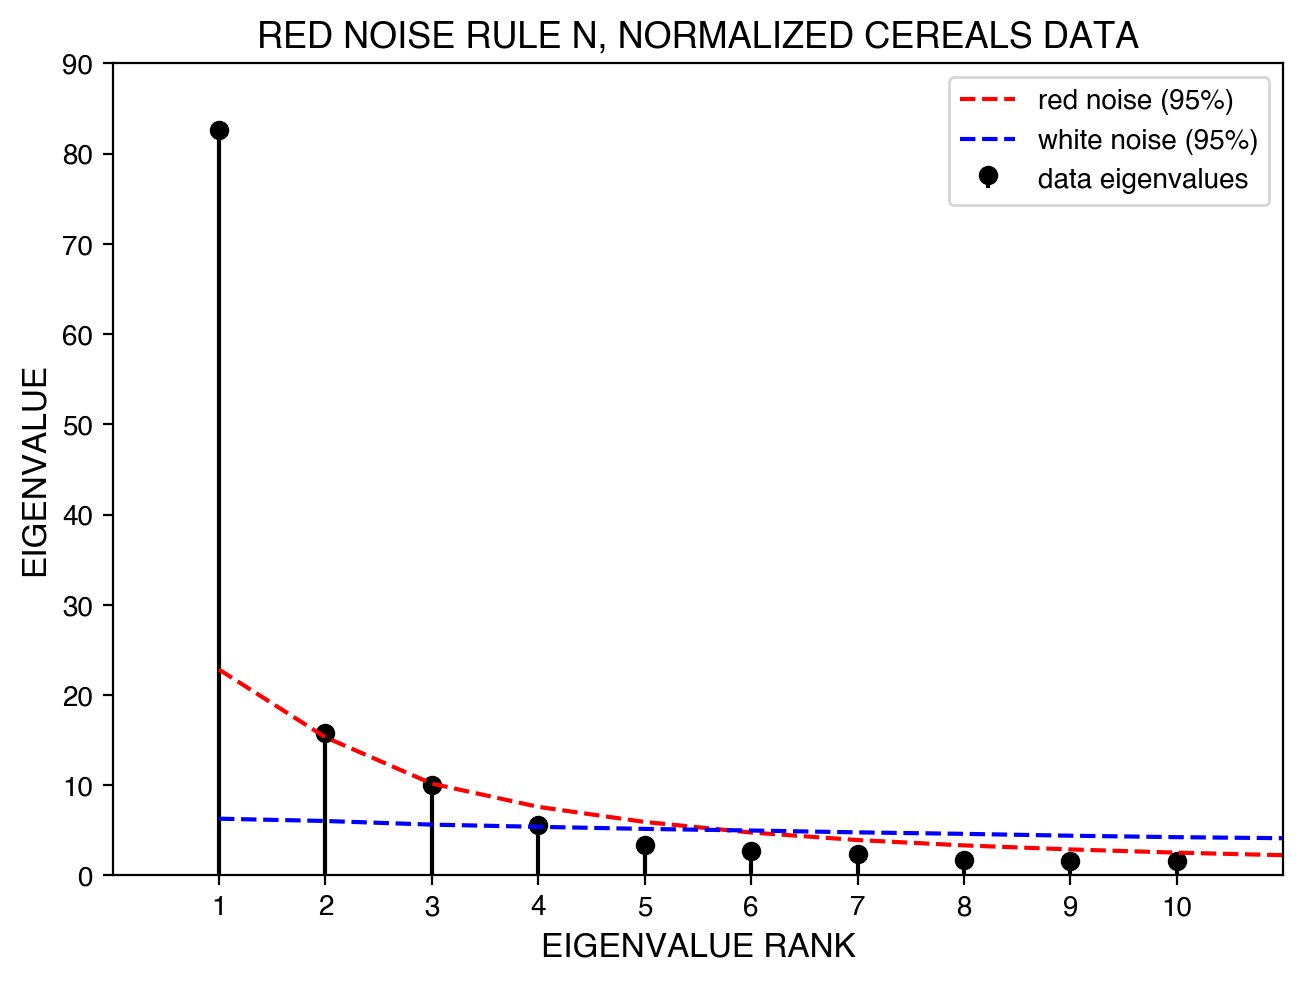

In [20]:
fig, (ax2) = plt.subplots(nrows=1,ncols=1,layout="constrained")

ax2.stem(np.arange(1,11),Sz[:10],basefmt=" ",markerfmt='ko',linefmt='k-',label='data eigenvalues')
ax2.set_ylim([0,90])
ax2.set_xlim([0,11])
ax2.plot(np.arange(1,len(Sz)+1),ci95ar,linestyle="--",color="red",label="red noise (95%)") # plot the red noise confidence interval
ax2.plot(np.arange(1,len(Sz)+1),ci95z,linestyle="--",color="blue",label="white noise (95%)") # plot the Gaussian noise confidence interval from earlier
ax2.legend()

ax2.set_xlabel('EIGENVALUE RANK',fontsize=12)
ax2.set_ylabel('EIGENVALUE',fontsize=12)
ax2.set_title("RED NOISE RULE N, NORMALIZED CEREALS DATA",fontsize=13)
ax2.set_xticks([1,2,3,4,5,6,7,8,9,10]);
